# Ordinal model

This messy notebook trains the XGboost model used in wikidit.

In [2]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import wikidit

In [3]:
from wikidit.preprocessing import _load_backlog, WP10_LABELS
from wikidit.io import read_labeled
from wikidit.ordinal import SequentialClassifier

# Train Model

In [4]:
import dill

In [5]:
import os
import os.path
import gzip
import json
import pandas as pd
from joblib import Parallel, delayed

In [6]:
output_dir = "../data/enwiki-labeling_revisions-w_features/"
revisions = read_labeled(output_dir)

In [325]:
from sklearn.model_selection import train_test_split

In [7]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
import dill
import itertools

from sklearn.preprocessing import FunctionTransformer, Binarizer

count_cols = ['words',
             # infobox as a binary
             'backlog_accuracy',
             'backlog_content',
             'backlog_other',
             'backlog_style',
             'backlog_links']

per_word_cols = [
             'headings_per_word',
             'sub_headings_per_word',
             # links
             'images_per_word',
             'categories_per_word',
             'wikilinks_per_word',
             'external_links_per_word',
             # templates
             'main_templates_per_word',
             'cite_templates_per_word',
             'ref_per_word'    
]

binarized_cols = ['coordinates', 'infoboxes']

response_col = ['wp10']

def create_features(df):
    df = df.copy()
    for c in count_cols:
        df[c] = np.sqrt(df[c])
    for c in binarized_cols:
        df[c] = df[c].astype(bool)
    allcols = list(itertools.chain(per_word_cols, count_cols, binarized_cols))
    return df.loc[:, allcols]

mapper = DataFrameMapper([
    (count_cols, FunctionTransformer(func=np.sqrt, validate=False)),
    (binarized_cols, Binarizer()),
    (per_word_cols, None)
])

X = revisions
y = revisions['wp10'].values

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, log_loss, 
                             confusion_matrix)
from sklearn.base import clone

In [9]:
xgb_params = {
  'silent': True,
  'booster': 'gbtree',
  'objective': 'binary:logistic',
  'random_state': 12345,
  'learning_rate': 0.1,
  'n_estimators': 200,
  'min_child_weight': 1,
  'gamma': 0,
  'subsample': 0.9,
  'colsample_bytree': 0.9,
  'max_depth': 6
}
# xgb_param_grid = {
#    'min_child_weight': list(range(1, 11)),
#    'gamma': [0.5, 1, 1.5, 2, 5],
#    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#    'max_depth': [2, 3, 4, 5, 6, 7, 8]
# }

clf = SequentialClassifier(xgb.XGBClassifier(**xgb_params))
pipeline = Pipeline([('mapper', mapper), ('clf', clf)])

In [10]:
fitted = clone(pipeline).fit(revisions, y)

KeyboardInterrupt: 

In [598]:
with open("../models/xgboost-sequential.pkl", "wb") as f:
    dill.dump(fitted, f)

## Example Code

Some code to check that things are working with live API data.

In [599]:
from wikidit.preprocessing import Featurizer
from wikidit.mw import get_page, Session
featurizer = Featurizer()
session = Session()
page = get_page(session, 'Correlation')
revision = featurizer.parse_content(page['content'])
del revision['text']
revision = pd.DataFrame.from_records([revision])

In [600]:
from wikidit.models import predict_page_edits
results = predict_page_edits(featurizer, page['content'], fitted)


## Logistic

In [601]:
# from sklearn.preprocessing import PolynomialFeatures
#from sklearn.feature_selection import VarianceThreshold
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.decomposition import PCA
#pipeline = Pipeline([('mapper', mapper), 
#                     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#                     ('var', VarianceThreshold()),
#                     ('PCA', PCA(whiten=True, n_components=30)),
#                     ('clf', SequentialClassifier(LogisticRegressionCV(cv=5, max_iter=200)))])

In [602]:
#[{'description': x[1], 'value': round(x[2] * 100)} 
#                     for x in results['top_edits']]

# Cross validation and testing

In [603]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
predictions = []
for train_idx, test_idx in skf.split(X, y):
    X_train = revisions.iloc[train_idx, :]
    y_train = y[train_idx]
    X_test = revisions.iloc[test_idx, :]
    y_test = y[test_idx]
    cv_fit = pipeline.fit(X_train, y_train)
    y_pred = cv_fit.predict(X_test)
    predictions.append(pd.DataFrame({'actual': y_test, 'pred': y_pred}))

predictions = pd.concat(predictions)


To account for the accuracy, average the number of correct binary classifications each observation, then average over all observations.

In [604]:
n_classes = len(predictions['actual'].cat.categories)
np.mean(1 - np.abs(predictions['actual'].cat.codes - predictions['pred'].cat.codes) / (n_classes - 1))

0.8989452257586973

In [605]:
confusion = predictions.groupby(['actual', 'pred']).aggregate(len).reset_index()
confusion = confusion.rename(columns={0: 'n'})
confusion['p'] = confusion['n'] / confusion['n'].sum()
actual_totals = confusion.groupby(['actual'])['n'].transform('sum')
confusion['p_actual'] = confusion['n'] / actual_totals

In [606]:
confusion_table = confusion.pivot(index='actual', columns='pred', values='p_actual').fillna(0)

In [607]:
import seaborn as sns
import matplotlib.pyplot as plt

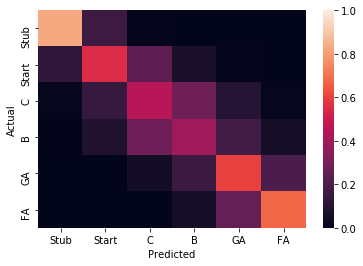

In [608]:
sns.heatmap(confusion_table, vmin=0, vmax=1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion-matrix.png')
plt.show()

# Tree of the Ordinal Model

Graphic of the tree of the ordinal model used in training.

In [609]:
from graphviz import Digraph

In [610]:
dot = Digraph(format='png')
dot.node('root', '')
dot.node('stub', 'P(Stub)')
dot.node('gtstub', 'P(x > Stub')
dot.node('start', 'P(Start)')
dot.node('gtstart', 'P(x > Start)')
dot.node('c', 'P(C)')
dot.node('gtc', 'P(x > C)')
dot.node('b', 'P(B)')
dot.node('gtb', 'P(x > B)')
dot.node('ga', 'P(GA)')
dot.node('fa', 'P(FA)')
dot.edges([['root', 'stub'], 
           ['root', 'gtstub'],
           ['gtstub', 'start'],
           ['gtstub', 'gtstart'],
           ['gtstart', 'c'],
           ['gtstart', 'gtc'],
           ['gtc', 'b'],
           ['gtc', 'gtb'],
           ['gtb', 'ga'],
           ['gtb', 'fa']            
          ])
print(dot.source)

digraph {
	root [label=""]
	stub [label="P(Stub)"]
	gtstub [label="P(x > Stub"]
	start [label="P(Start)"]
	gtstart [label="P(x > Start)"]
	c [label="P(C)"]
	gtc [label="P(x > C)"]
	b [label="P(B)"]
	gtb [label="P(x > B)"]
	ga [label="P(GA)"]
	fa [label="P(FA)"]
	root -> stub
	root -> gtstub
	gtstub -> start
	gtstub -> gtstart
	gtstart -> c
	gtstart -> gtc
	gtc -> b
	gtc -> gtb
	gtb -> ga
	gtb -> fa
}


In [557]:
dot.render('model.gv', view=True)

'model.gv.png'

# Information on Training Set

In [18]:
revisions.groupby('wp10')['wp10'].count()

wp10
Stub     5486
Start    5476
C        5485
B        5486
GA       5495
FA       4996
Name: wp10, dtype: int64

# Parameter Tuning

In [516]:
from sklearn.model_selection import ParameterSampler

xgb_param_grid = {
    'clf__estimator__min_child_weight': list(range(1, 11)),
    'clf__estimator__gamma': [0.5, 1, 1.5, 2, 5],
    'clf__estimator__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__estimator__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__estimator__max_depth': [2, 3, 4, 5, 6, 7, 8]
}

In [517]:
list(ParameterSampler(xgb_param_grid, 5))

[{'clf__estimator__subsample': 0.8,
  'clf__estimator__min_child_weight': 2,
  'clf__estimator__max_depth': 6,
  'clf__estimator__gamma': 1,
  'clf__estimator__colsample_bytree': 0.7},
 {'clf__estimator__subsample': 0.7,
  'clf__estimator__min_child_weight': 4,
  'clf__estimator__max_depth': 8,
  'clf__estimator__gamma': 1.5,
  'clf__estimator__colsample_bytree': 1.0},
 {'clf__estimator__subsample': 0.8,
  'clf__estimator__min_child_weight': 5,
  'clf__estimator__max_depth': 6,
  'clf__estimator__gamma': 5,
  'clf__estimator__colsample_bytree': 0.5},
 {'clf__estimator__subsample': 0.5,
  'clf__estimator__min_child_weight': 6,
  'clf__estimator__max_depth': 2,
  'clf__estimator__gamma': 2,
  'clf__estimator__colsample_bytree': 0.6},
 {'clf__estimator__subsample': 1.0,
  'clf__estimator__min_child_weight': 5,
  'clf__estimator__max_depth': 2,
  'clf__estimator__gamma': 1,
  'clf__estimator__colsample_bytree': 1.0}]

In [518]:
#X = create_features(revisions)

rnd_search_pars = {'n_iter': 2, 'n_jobs': 3, 'cv': 2}

rnd_search = RandomizedSearchCV(pipeline, xgb_param_grid, scoring='neg_log_loss',
                                random_state=1234, refit=True,
                                **rnd_search_pars)
rnd_search.fit(revisions, y)

TypeError: take_nd() got an unexpected keyword argument 'axis'

In [ ]:
y_pred = pipeline.predict(X_test)
prob_pred = pipeline.predict_proba(X_test)

In [ ]:
scores[cat] = {
    'f1': f1_score(y_test, y_pred),
    'recall_score': recall_score(y_test, y_pred),
    'precision_score': precision_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred),
    'roc_auc_score': roc_auc_score(y_test, y_pred),
    'log_loss': log_loss(y_test, prob_pred)
}

After finding best parameter values for all models, refit using the entire sample.

# Feature Importances

In [611]:
import matplotlib.pyplot as plt
for cat, model in model.named_steps['clf'].named_estimators_.items():
    xgb.plot_importance(model)
    plt.title(f"Feature importance for {cat}")
    plt.show()

AttributeError: 'LogisticRegressionCV' object has no attribute 'named_steps'

In [511]:
model

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

# Check one page

In [34]:
from wikidit.mw import get_page, Session

In [35]:
session = Session()
page = get_page(session, "Data science")

ConnectionError: HTTPSConnectionPool(host='en.wikipedia.org', port=443): Max retries exceeded with url: /w/api.php?action=query&titles=Data+science&prop=revisions&redirects=True&rvprop=ids%7Ccontent%7Ctimestamp&rvslots=main&format=json (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0xa22aa4d30>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [36]:
from wikidit.preprocessing import Featurizer
featurizer = Featurizer()

In [37]:
featurized = featurizer.featurize(page)

In [31]:
from wikidit.models import predict_page_edits

In [120]:
import dill
with open("../models/xgboost-sequential.pkl", "rb") as f:
    MODEL = dill.load(f) 

In [121]:
title = "Data science"
# session = Session()
# page = get_page(session, title)
# result = predict_page_edits(featurizer, page['content'], MODEL)

In [122]:
from wikidit.models import qual_score, make_edits
content = page['content']
featurizer = Featurizer()
model = MODEL
revision = featurizer.parse_content(content)
del revision['text']
revision = pd.DataFrame.from_records([revision])
# revision = create_features(revision)

# probabilities for current class
prob = model.predict_proba(revision)
best = str(model.predict(revision)[0])
score = qual_score(prob)

# Calc new probabilities for all types of edits
edits = [(nm, description, pd.DataFrame.from_records([x])) 
         for nm, x, description in make_edits(revision.to_dict('records')[0])]
edit_probs = [(nm, description, model.predict_proba(ed)) for nm, description, ed in edits]
edit_scores = [(nm, description, qual_score(p)) for nm, description, p in edit_probs]
edit_changes = [(n, d, s - score) for n, d, s in edit_scores]
top_edits = sorted([x for x in edit_changes if x[2] > 0], key=lambda x: -x[2])


In [123]:
import numpy as np
np.round(prob, 2)

array([[0.  , 0.  , 0.26, 0.26, 0.37, 0.1 ]])

In [124]:
result['top_edits']

[('infoboxes',
  '<a href="https://en.wikipedia.org/wiki/Wikipedia:Manual_of_Style/Infoboxes">Add an infobox</a>',
  0.40727842903825273),
 ('words', 'Add a sentence (15 words)', 0.023514236413411993)]

In [125]:
for w, d, data in edits:
    print(w)

words
headings
sub_headings
images
categories
wikilinks
external_links
citation
ref
coordinates
infoboxes
backlog_accuracy
backlog_other
backlog_style
backlog_links


In [126]:
for w, d, data in edits:
    if w in ('words', 'infoboxes', 'ref'):
        print(data.loc[:, ['words', 'infoboxes', 'ref']])

   words  infoboxes  ref
0   1887          0   60
   words  infoboxes  ref
0   1875          0   60
   words  infoboxes  ref
0   1872       True   60


In [127]:
for w, d, data in edit_probs:
    if w in ('words', 'infoboxs'):
        print(np.round(data, 2))

[[0.   0.   0.25 0.27 0.38 0.1 ]]
[[0.   0.   0.17 0.1  0.56 0.16]]


In [128]:
for w, d, data in edit_scores:
    if w in ('words', 'infoboxes'):
        print(np.round(data, 2))    

4.32
4.7


In [129]:
score

4.29364713400031

In [130]:
4.7 - 4.29

0.41000000000000014

In [131]:
4.32 - 4.29

0.03000000000000025

In [132]:
revision

,backlog_accuracy,backlog_accuracy_templates,backlog_content,backlog_content_templates,backlog_files,backlog_files_templates,backlog_links,backlog_links_templates,backlog_other,backlog_other_templates,...,ref_per_word,smartlists,smartlists_per_word,sub_headings,sub_headings_per_word,templates,templates_per_word,wikilinks,wikilinks_per_word,words
0,0,None,0,None,0,None,0,None,0,None,...,0.032051,0,0.0,0,0.0,42,0.022436,84,0.044872,1872


In [133]:
from wikidit.models import make_edits, add_per_word, add_count